## In this project, you will create a short-term temperature forecast.

    1) Get and clean temperature data from www.ecad.eu

    2) Build a baseline model modelling trend and seasonality

    3) Plot and inspect the different components of a time series

    4) Model time dependence of the remainder using an AR model

    5) Compare the statistical output of different AR models

    6) Test the remainder for stationarity

    7) upload your code to GitHub

### Step 0 - import libraries

In [1]:
# data analysis stack
import numpy  as np
import pandas as pd
from datetime import datetime

# data visualization stack
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# machine learning | time series stack
from sklearn.linear_model          import LinearRegression
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools     import adfuller
from statsmodels.tsa.ar_model      import AutoReg, ar_select_order
from statsmodels.tsa.arima.model   import ARIMA
from sklearn.metrics               import mean_squared_error
#!pip install pmdarima
from pmdarima.arima                import auto_arima

# miscellaneous
import warnings
warnings.filterwarnings("ignore")

# Set the figure size to (14,6)
plt.rcParams['figure.figsize'] = (14,6)

### Step 1 - get and read data

  - List the data you need and how much you need.

  - Find and document where you can get the data.

  - Check how much space it will take.

  - Check legal obligations, and get authorizations if necessary.

  - Get access authorizations.

  - Create a workspace (with enough storage space).

  - Get the data.

  - Convert the data to a format you can easily manipulate (without changing the data itself).

  - Ensure sensitive information is deleted or protected (e.g. anonymized).

  - Check the size and type of data (time series, sample, geographical, etc.).

  - Sample a test set, put it aside, and never look at it (no data snooping!).

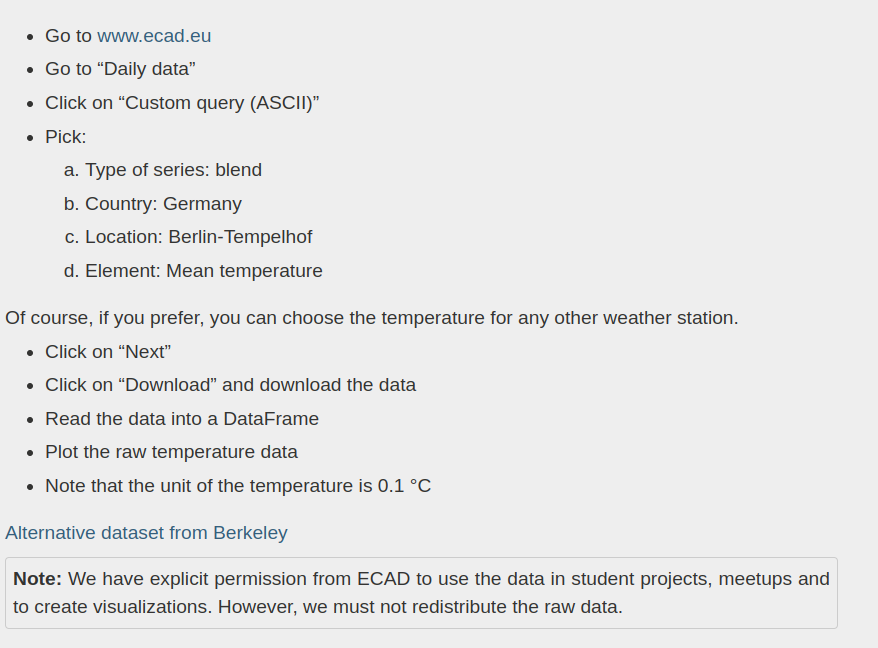



EUROPEAN CLIMATE ASSESSMENT & DATASET (ECA&D), file created on 10-10-2022
THESE DATA CAN BE USED FREELY PROVIDED THAT THE FOLLOWING SOURCE IS ACKNOWLEDGED:

Klein Tank, A.M.G. and Coauthors, 2002. Daily dataset of 20th-century surface
air temperature and precipitation series for the European Climate Assessment.
Int. J. of Climatol., 22, 1441-1453.
Data and metadata available at http://www.ecad.eu

FILE FORMAT (MISSING VALUE CODE IS -9999):

01-06 SOUID: Source identifier
08-15 DATE : Date YYYYMMDD
17-21 TG   : mean temperature in 0.1 &#176;C
23-27 Q_TG : Quality code for TG (0='valid'; 1='suspect'; 9='missing')

This is the blended series of station GERMANY, BERLIN-TEMPELHOF (STAID: 2759).
Blended and updated with sources: 100133 111448 127488 128124 
See file sources.txt and stations.txt for more info.

In [2]:
# the txt-file contains information as seen above. therefore we skip the first 18 rows.
PATH = '/home/florianriemann/data_science_portfolio/boot_camp/data/data_temperature/'
df_temp = pd.read_csv(PATH + 'TG_STAID002759.txt', delimiter = ",", skiprows = 18)

In [3]:
# the information in TG is the temperature in celsius multiplied by 10
df_temp.head(5)

,SOUID,DATE,TG,Q_TG
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0


Some data inspection and cleaning before train-test-split ...

In [4]:
# rename the columns
df_temp.columns = ['id', 'date', 'temp', 'quality']

In [5]:
# id = weather station, date needs to be converted into datetime and will use it as index
df_temp.head()

,id,date,temp,quality
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0


checking data coming from different stations ('id')

In [6]:
df_temp['id'].nunique()

4

In [7]:
df_temp['id'].unique()

array([127488, 128124, 111448, 100133])

In [8]:
# have to keep in mind that there are (0 = 'valid'; 1 = 'suspect'; 9 = 'missing') - we will investigate that 
df_temp['quality'].value_counts()

0    53372
9      196
1        1
Name: quality, dtype: int64

In [9]:
# the temp -9999 corresponds to 9 and -27 corresponds to 1. So the columns id and quality can be drop
df_temp[df_temp['quality'].isin([1, 9])]['temp'].unique() 

array([-9999,   -27])

In [10]:
df_temp.drop(['id', 'quality'], axis = 1, inplace = True)
df_temp.head()

,date,temp
0,18760101,22
1,18760102,25
2,18760103,3
3,18760104,-58
4,18760105,-98


In [11]:
# next change the datatype of the date and set the date as index
df_temp['date'] = df_temp['date'].astype(str)
df_temp['date'] = pd.to_datetime(df_temp['date'])
df_temp = df_temp.set_index("date")
df_temp.head()

,temp
date,
1876-01-01,22
1876-01-02,25
1876-01-03,3
1876-01-04,-58
1876-01-05,-98


<AxesSubplot:xlabel='date'>

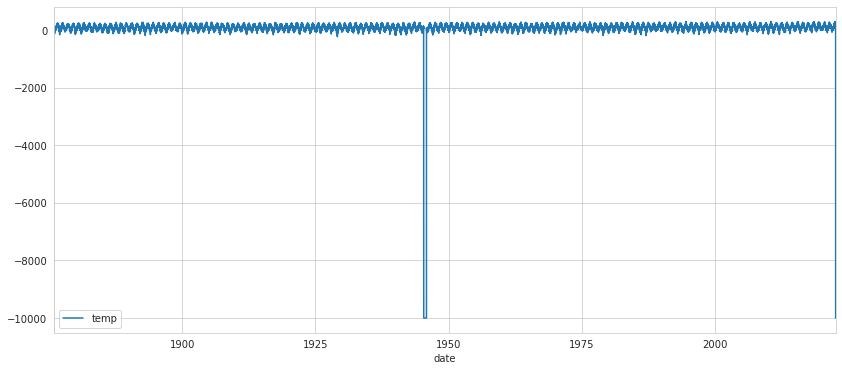

In [12]:
# take a first look at some plotting
df_temp.plot()

In [13]:
# the time series goes from 1876 till 2022, but as seen in the plot above the seem something wrong with the measurements around 1944 that most probably has to do with WWII
print (df_temp.index.min())
print (df_temp.index.max())

1876-01-01 00:00:00
2022-08-31 00:00:00


<AxesSubplot:xlabel='date'>

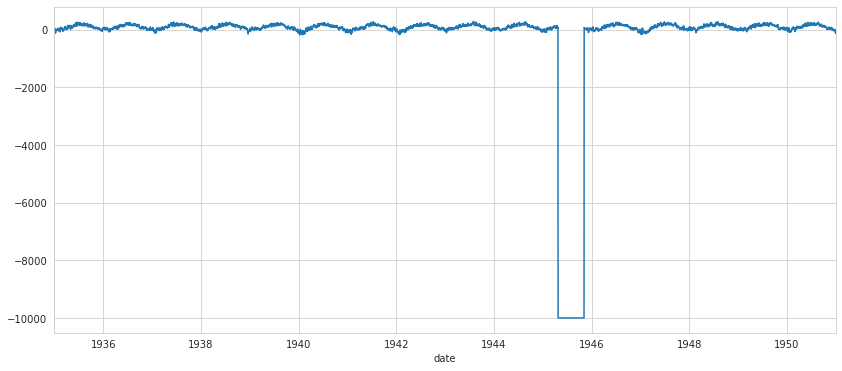

In [14]:
# closer look to the time around 1945
df_temp['temp'].loc['1935':'1950'].plot()

<AxesSubplot:xlabel='date'>

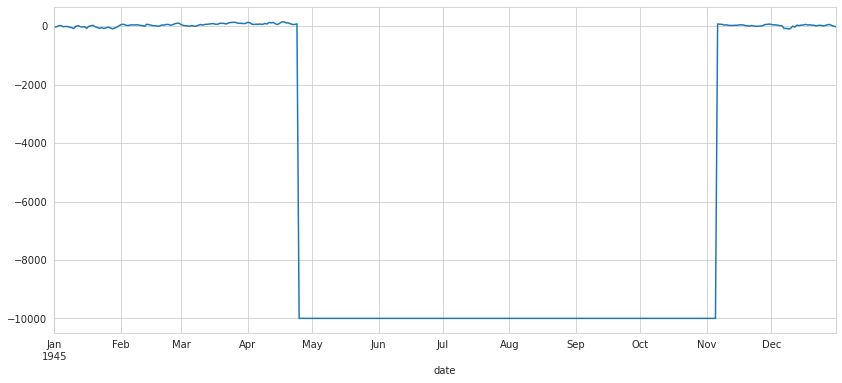

In [15]:
# closer look to the time around 1945. there is obviously missing data around 1945 that needs to be replaced
df_temp['temp'].loc['1945'].plot()

In [16]:
df_temp["year"]  = df_temp.index.year
df_temp["month"] = df_temp.index.month
df_temp["day"]   = df_temp.index.day

In [17]:
# replace the these missing values with the mean per every day from all measurements from the years before
groupmeans = df_temp.groupby(['month','day'])['temp'].transform('mean')

In [18]:
groupmeans

date
1876-01-01      2.000000
1876-01-02      4.319728
1876-01-03      5.619048
1876-01-04      4.551020
1876-01-05      2.428571
                 ...    
2022-08-27    103.891156
2022-08-28    101.700680
2022-08-29    100.258503
2022-08-30    100.639456
2022-08-31     28.782313
Name: temp, Length: 53569, dtype: float64

In [19]:
# replace -9999 with nan, so that we can use the fillna method
import numpy as np

df_temp["temp"][df_temp.temp == -9999] = np.nan

In [20]:
# replace the these missing values with the mean per every day from all measurements from the years before
df_temp['temp'].fillna(groupmeans, inplace = True)

<AxesSubplot:xlabel='date'>

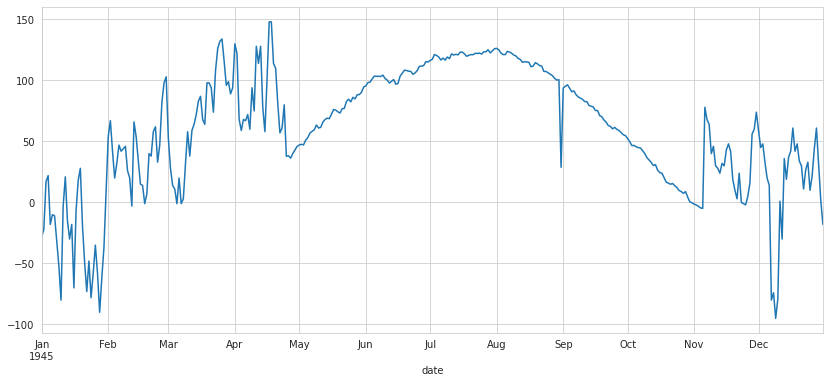

In [21]:
# lets check 1945 again and see if that worked
df_temp['temp'].loc['1945'].plot() 

# this does not look perfect but we'll see if it is contributing something to the model

In [22]:
clean_data = df_temp[['temp']]*0.1

In [23]:
clean_data.head()

,temp
date,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3
1876-01-04,-5.8
1876-01-05,-9.8


### Step 2 - train-test-split

In [24]:
data_train = clean_data.loc[:'2020']
data_train.info()
data_train.to_csv(PATH + "climate_train.csv")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52961 entries, 1876-01-01 to 2020-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    52961 non-null  float64
dtypes: float64(1)
memory usage: 827.5 KB


In [25]:
data_test = clean_data.loc['2021']
data_test.info()
data_test.to_csv(PATH + "climate_test.csv")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2021-01-01 to 2021-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


<hr style="border:2px solid black">

*Don't get biased by any stretch of the imagination. Do the train-test-split as early as possible!*

<hr style="border:2px solid black">

### Step 3 - exploratory data analysis

#### Step 3.0 - workflow

  - Create a copy of the data exploration (sampling it down to a manageble size if necessary).

  - Create a notebook to keep a record of your data exploration.

  - Study each attribute and its characteristics:

    - Name
    - Type (categorical, int/float, bounded/unbounded, text, structured, etc.)
    - % of missing values
    - Noisiness and type of noise (stoxastoc, outliers, rounding errors, etc.)
    - Possibly useful for the task?
    - Type of distribution (Gaussian, uniform, logarithmic, etc.)
  - For supervised learning tasks, identify target attribute(s).

  - Visualize the data.

  - Study the correlation between attributes.

  - Study how you would solve the problem manually.

  - Identify the promising transformations you may want to apply.

  - Identify extra data that would be useful.

  - Document what you have learned.

#### Step 3.1 - general overview

##### **Categorical:**

- `Nominal`

>- <u>Cabin</u> - Cabin number   
>- <u>Embarked</u> - Port of Embarkation ( C = Cherbourg | Q = Queenstown | S = Southampton )

- `Dichotomous`

>- <u>Sex</u> - ( Female | Male )

- `Ordinal`
    
>- <u>Pclass</u> - Ticket class ( 1 = 1st | 2 = 2nd | 3 = 3rd )
    * A proxy for socio-economic status (SES)
        - 1st = Upper
        - 2nd = Middle
        - 3rd = Lower

##### **Numeric:**

- `Discrete`

>- <u>Passenger ID</u>
>- <u>SibSp</u> - # of siblings / spouses aboard the Titanic	
    * sibsp: The dataset defines family relations in this way...
        - Sibling = brother, sister, stepbrother, stepsister
        - Spouse  = husband, wife (mistresses and fiancés were ignored)
>- <u>Parch</u> - # of parents / children aboard the Titanic
    * parch: The dataset defines family relations in this way...
        - Parent = mother, father
        - Child  = daughter, son, stepdaughter, stepson
        - Some children travelled only with a nanny, therefore parch = 0 for them.
>- <u>Survived</u> - ( 0 = Not Survived | 1 = Surived ) 

- `Continous`

>- <u>Age</u> - Age in years
    * Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

>- <u>Fare</u> - Passenger fare

##### **Text:**

- <u>Ticket</u> - Ticket number
- <u>Name</u> - Name of passenger

#### Step 3.2 - descriptive statistics

#### Step 3.3 - observe some features in more detail

##### Step 3.2.1 - PassengerId

##### Step 3.2.2 - Pclass

##### Step 3.2.3 - Name

##### Step 3.2.4 - Sex

##### Step 3.2.5 - Age

##### Step 3.2.6 - SibSp

##### Step 3.2.7 - Parch

##### Step 3.2.8 - Ticket

##### Step 3.2.9 - Fare

##### Step 3.2.10 - Cabin

##### Step 3.2.11 - Embarked

##### Step 3.2.12 - Survived

### **Conclusion from the EDA**

<hr style="border:2px solid black">

    - ....
<hr style="border:2px solid black">

### Step 4 - cleaning & scaling

   - *Fix or remove outliers (otional).*
   - *Fill in missing values (e.g. with zero, mean, median ...) or drop their rows (or columns).*
   - *Standadize or nomalize features*

#### Step 4.1 - impute missing values

#### Step 4.2 - scaling

#### Step 4.3 - interpolation

#### Step 4.4 - remove duplicates and outliers

### Step 5 - feature engineering

   - *Discretize continious features.*
   - *Decompose features (e.g. categorical, date/time, etc.).*
   - *Add promising transformations of features (e.g. log(x), sqrt(x), x^2, etc.).*
   - *Aggregate features into promising new features.*

#### Step 5.1 - feature extraction, decomposition and transformation

#### Step 5.2 - encoding of categorical features

#### Step 5.3 - discretizing of continious features

#### Step 5.4 - drop features

#### Step 5.5 - sampling strategy in case of imbalanced data

#### Step 5.6 - implement polynomials

### Step 6 - baseline model

In [26]:
PATH

'/home/florianriemann/data_science_portfolio/boot_camp/data/data_temperature/'

In [27]:
train = pd.read_csv(PATH + 'climate_train.csv', index_col = 0, parse_dates = True)

In [28]:
train.head()

,temp
date,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3
1876-01-04,-5.8
1876-01-05,-9.8


In [29]:
# only the data from 1975 onwards will be used
train = train[train.index > '1974-12-31']

In [30]:
# engineer timestep variable for future convenience
train['timestep'] = list(range(train.shape[0]))
# why do we need the timestep and why do we square it up?
train['t²'] = train['timestep']**2 

In [31]:
train.head()

,temp,timestep,t²
date,,,
1975-01-01,6.4,0,0
1975-01-02,7.3,1,1
1975-01-03,4.8,2,4
1975-01-04,6.1,3,9
1975-01-05,7.5,4,16


In [32]:
# feature and target for trend model
X_trend = train[['timestep','t²']]
y_trend = train['temp']

In [33]:
trend_model = LinearRegression()

# Fit a linear function of the timestep to data
trend_model.fit(X_trend, y_trend)

LinearRegression()

In [34]:
# predict from fitted model
train['trend'] = trend_model.predict(X_trend)

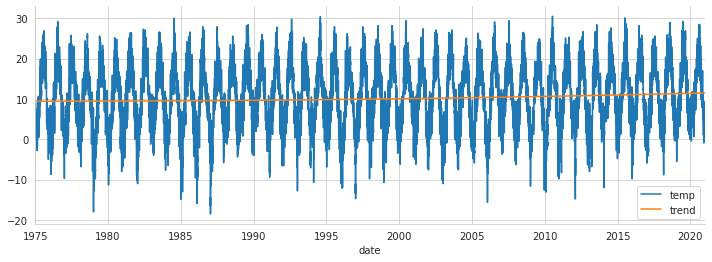

In [35]:
train[['temp','trend']].plot(figsize=(12,4),legend=True)
sns.despine()

In [36]:
# subtract trend from data
train['detrended'] = train['temp'] - train['trend']

In [37]:
# create month and days column
train['month'] = train.index.month
train['day']   = train.index.day

In [38]:
# create dummy columns for months
seasonal_dummies_month = pd.get_dummies(
    train['month']       , 
    prefix     = 'month' , 
    drop_first =  True
).set_index(train.index)

In [39]:
# create dummy columns for months
seasonal_dummies_days = pd.get_dummies(
    train['day']       , 
    prefix     = 'day' , 
    drop_first = True
).set_index(train.index)

In [40]:
# concatenate all three data frames along the vertical axis
train = pd.concat([train, seasonal_dummies_month, seasonal_dummies_days], axis=1)

In [41]:
train.columns

Index(['temp', 'timestep', 't²', 'trend', 'detrended', 'month', 'day',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'day_2',
       'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10',
       'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17',
       'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24',
       'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31'],
      dtype='object')

In [42]:
train[train.columns[7:]].head()

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
date,,,,,,,,,,,,,,,,,,,,,
1975-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1975-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1975-01-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1975-01-04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1975-01-05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
# feature and target for the seasonality model
X_seasonality = train[train.columns[5:]] # all dummy features but not ['temp', 'timestep', 't²', 'trend', 'detrended', 'month', 'day']
y_seasonality = train['detrended']

In [44]:
# fit seasonality model
seasonality_model = LinearRegression()
seasonality_model.fit(X_seasonality, y_seasonality)

LinearRegression()

In [45]:
# predict from fitted model
train['seasonality'] = seasonality_model.predict(X_seasonality)

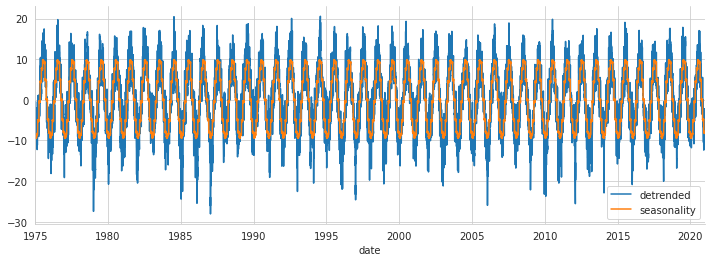

In [46]:
train[['detrended','seasonality']].plot(figsize=(12,4),legend = True)
sns.despine()

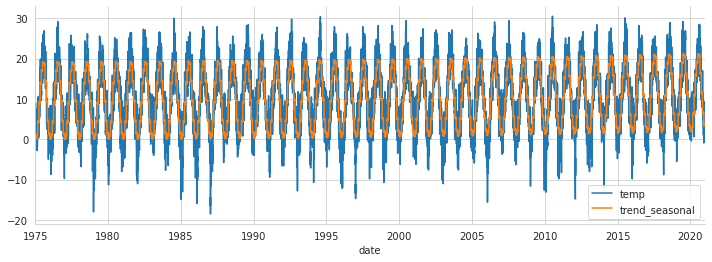

In [47]:
# combine trend and seasonality
train['trend_seasonal'] = train['trend'] + train['seasonality']

train[['temp','trend_seasonal']].plot(figsize = (12,4),legend = True)
sns.despine()

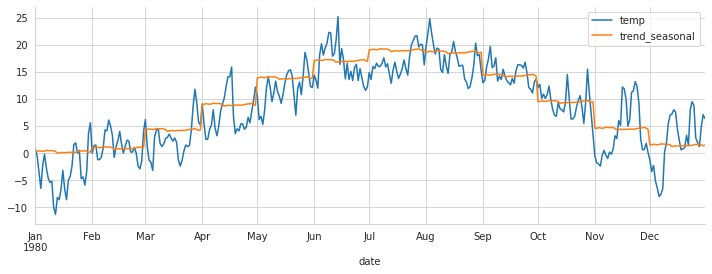

In [48]:
train[['temp','trend_seasonal']].loc['1980'].plot(figsize = (12,4), legend = True)
sns.despine()

In [49]:
# leftover time series devoid of trend and seasonality
train['remainder'] = train['temp'] - train['trend_seasonal']

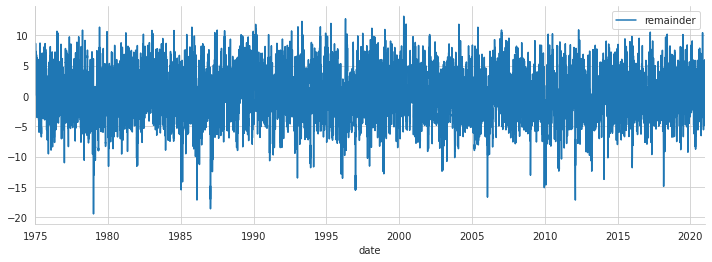

In [50]:
train['remainder'].plot(figsize=(12,4),legend=True)
sns.despine()

In [51]:
train.head()

,temp,timestep,t²,trend,detrended,month,day,month_2,month_3,month_4,...,day_25,day_26,day_27,day_28,day_29,day_30,day_31,seasonality,trend_seasonal,remainder
date,,,,,,,,,,,,,,,,,,,,,
1975-01-01,6.4,0,0,9.434538,-3.034538,1,1,0,0,0,...,0,0,0,0,0,0,0,-9.173212,0.261327,6.138673
1975-01-02,7.3,1,1,9.434540,-2.134540,1,2,0,0,0,...,0,0,0,0,0,0,0,-9.148514,0.286026,7.013974
1975-01-03,4.8,2,4,9.434542,-4.634542,1,3,0,0,0,...,0,0,0,0,0,0,0,-9.030882,0.403661,4.396339
1975-01-04,6.1,3,9,9.434545,-3.334545,1,4,0,0,0,...,0,0,0,0,0,0,0,-9.086076,0.348469,5.751531
1975-01-05,7.5,4,16,9.434547,-1.934547,1,5,0,0,0,...,0,0,0,0,0,0,0,-9.148154,0.286393,7.213607


In [52]:
####################################################################
### ARIMA
####################################################################
### SARIMA
####################################################################

In [53]:
df_remaider = train['remainder'].reset_index()
df_remaider.to_csv(PATH + 'temp_remainder.csv',index = False)

In [54]:
df = df_remaider[['remainder']]

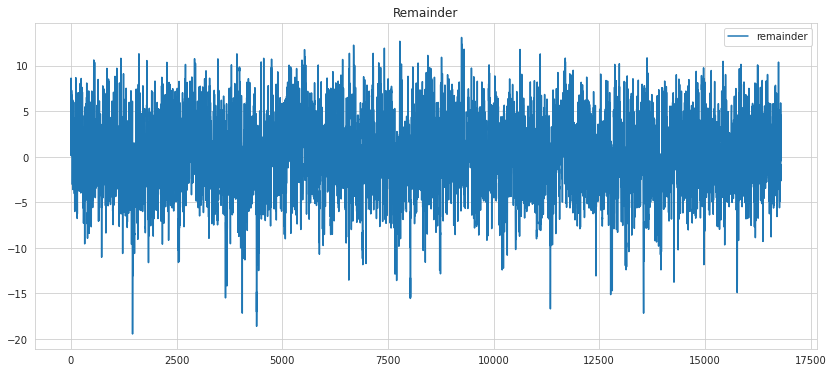

In [55]:
df.plot()
plt.title('Remainder')
plt.show()

In [56]:
df.mean()

remainder    1.197947e-15
dtype: float64

In [57]:
# What is stationarity? https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322
# What is the Dicky-Fuller stationarity test? https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/#:~:text=Augmented%20Dickey%20Fuller%20test%20(ADF%20Test)%20is%20a%20common%20statistical,the%20stationary%20of%20a%20series.
# What is the AIC? 

In [58]:
# apply the augmented Dicky-Fuller stationarity test

# recap: The null hypothesis is that the time series is NOT-stationary
# i.e. a small p value, less than 0.05, means that you have a stationary series

def print_adf(data):
    """ 
    Prints the results of the augmented Dickey Fuller Test
    """
    adf_stats, p, used_lag, n_obs, levels, information_criterion = adfuller(data) # What is adfuller?
    
    print(f""" 
              adf_stats: {adf_stats}
              p: {p} 
              used lag: {used_lag} 
              number of observations: {n_obs}
            
              CI 99%: {levels['1%']}
              CI 95%: {levels['5%']}
              CI 90%: {levels['10%']}
              information criterion (AIC): {information_criterion}
            """)

In [59]:
print_adf(df['remainder'])

 
              adf_stats: -38.20171160949128
              p: 0.0 
              used lag: 3 
              number of observations: 16798
            
              CI 99%: -3.430739349896841
              CI 95%: -2.861712077163693
              CI 90%: -2.5668615922861227
              information criterion (AIC): 75265.43906223783
            


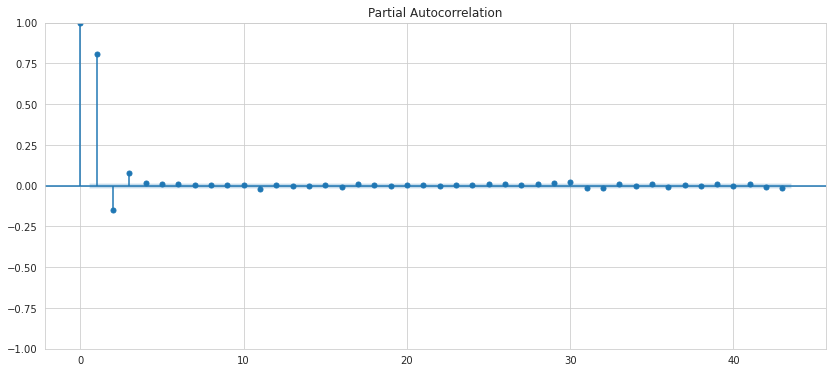

In [60]:
# Plot the partial autocorrelation function
plot_pacf(df['remainder']);

plt.show()

In [61]:
# Use ar_select_order - brute force method that tries different models and takes the best one

order = ar_select_order(df, maxlag = 20, old_names = False)

In [62]:
# How many lags does ar_select_order suggest?

order.ar_lags

[1, 2, 3]

In [63]:
# Fit a statsmodels AutoReg model
# pure autoregressive model: AR3
ar_model = AutoReg(df['remainder'], lags = 3, old_names = False).fit()

In [64]:
df['remainder']

0        6.138673
1        7.013974
2        4.396339
3        5.751531
4        7.213607
           ...   
16797   -1.992879
16798   -0.906947
16799   -1.233428
16800   -0.850516
16801   -0.871187
Name: remainder, Length: 16802, dtype: float64

In [65]:
ar_model.predict()

0             NaN
1             NaN
2             NaN
3        3.052029
4        4.978119
           ...   
16797   -2.017365
16798   -1.351479
16799   -0.616194
16800   -1.114762
16801   -0.596283
Length: 16802, dtype: float64

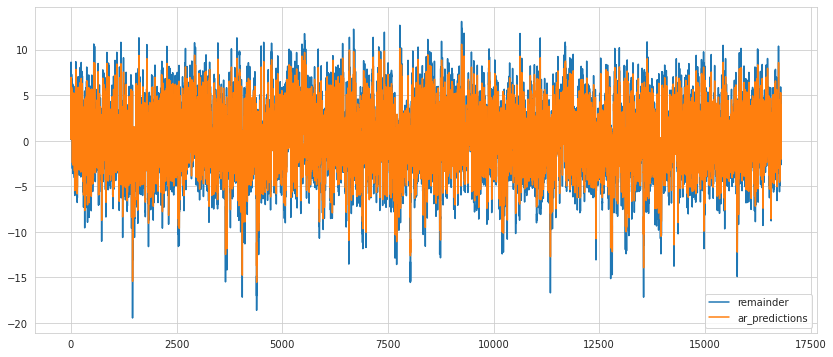

In [66]:
# Plot the prediction

df['remainder'].plot()
plt.plot(ar_model.predict(), label = 'ar_predictions') # insample prediction
plt.legend()
plt.show()

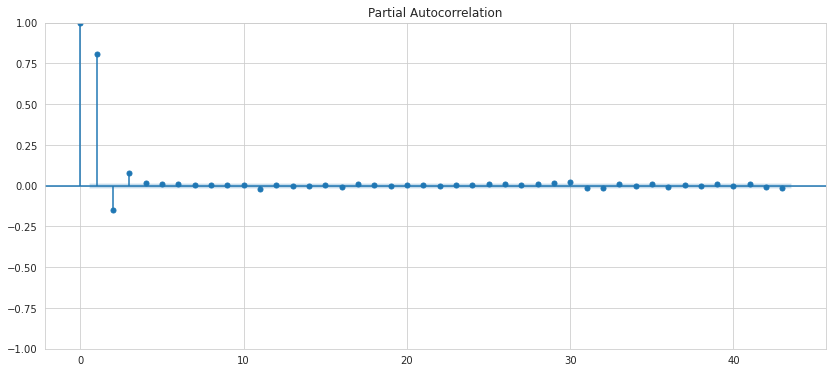

In [67]:
# let's examine both plots now

plot_pacf(df['remainder']);

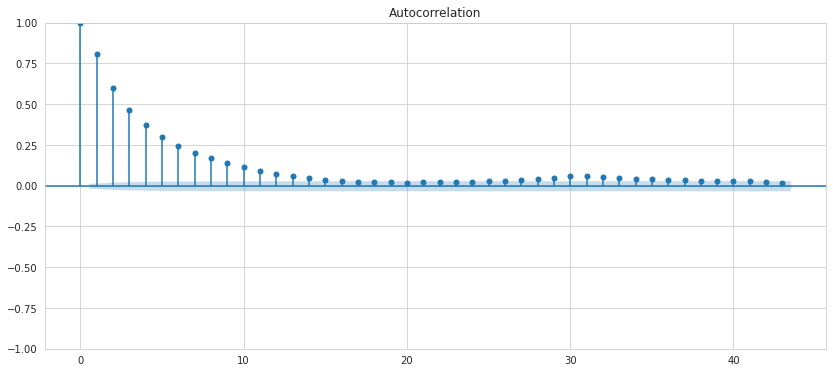

In [68]:
plot_acf(df['remainder']);

In [69]:
# ARIMA(p,d,q)

# p = number of AR lags
# q = number of MA lags
# d = the order of integration (if the data is stationary, d = 0)

auto_arima_model = auto_arima(df['remainder'], 
                              start_p = 0    , 
                              start_q = 0    , 
                              max_p   = 10   , 
                              max_q   = 10   , 
                              d       = 0    ,
                              trace   = True
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=93650.258, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=75949.106, Time=0.49 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=81936.706, Time=1.41 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=93648.258, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=75571.143, Time=0.87 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=75467.573, Time=1.12 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=75465.258, Time=1.35 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=75466.222, Time=1.96 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=75463.795, Time=12.09 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=75464.026, Time=5.65 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=75469.116, Time=3.62 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=75468.016, Time=7.60 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=75464.138, Time=5.77 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=75467.258, Time=12.88 sec
 ARIMA(4,0,1)(0,0

In [70]:
auto_arima_model

ARIMA(order=(4, 0, 1), scoring_args={}, suppress_warnings=True)

In [71]:
temp_train = pd.read_csv(PATH + 'climate_train.csv', index_col = 0, parse_dates = True)
# lets use only the data from 1975 onwards
temp_train = temp_train[temp_train.index > '1974-12-31']

In [72]:
temp_train.head()

,temp
date,
1975-01-01,6.4
1975-01-02,7.3
1975-01-03,4.8
1975-01-04,6.1
1975-01-05,7.5


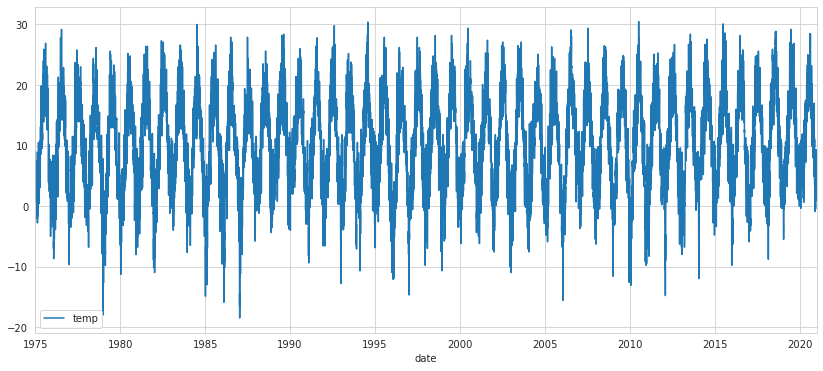

In [73]:
temp_train.plot();

In [74]:
### we can already see that there is trend and seasonality in the series, meaning it is non-stationary

test_result=adfuller(temp_train['temp'])

print('ADF Statistic: %f' % test_result[0])
print('p-value: %f' % test_result[1])

ADF Statistic: -9.296362
p-value: 0.000000


In [75]:
# Ho - null hypothesis: series is non stationary
# H1 - alternative hypothesis: series is stationary

def adfuller_test(series):
    result=adfuller(series)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis, indicating data is non-stationary")

        
adfuller_test(temp_train['temp'])

ADF Test Statistic : -9.296361574588072
p-value : 1.143306490958226e-15
#Lags Used : 43
Number of Observations Used : 16758
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [76]:
# what to do if the time seris has a trend ?

temp_train['diff1'] = temp_train['temp'].diff(1)

temp_train.head()

,temp,diff1
date,,
1975-01-01,6.4,NaN
1975-01-02,7.3,0.9
1975-01-03,4.8,-2.5
1975-01-04,6.1,1.3
1975-01-05,7.5,1.4


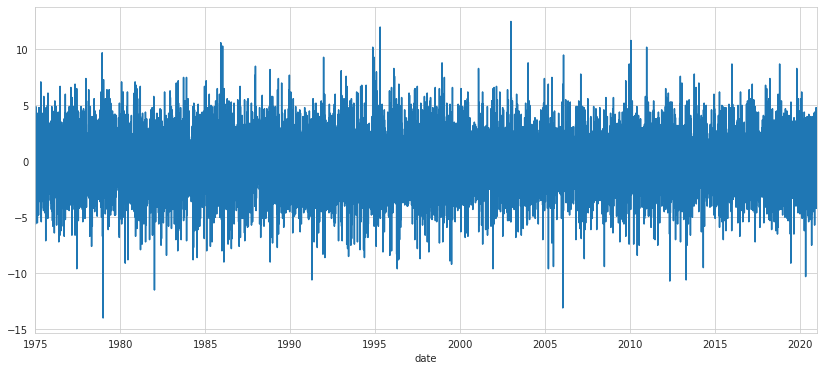

In [77]:
# plot the differenced signal and inspect results of adfuller test

temp_train['diff1'].plot();

In [78]:
adfuller_test(temp_train['diff1'].dropna())

ADF Test Statistic : -36.234930407577714
p-value : 0.0
#Lags Used : 21
Number of Observations Used : 16779
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


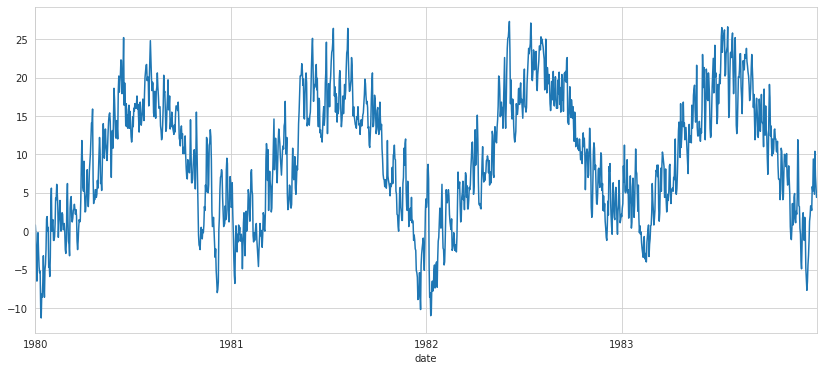

In [79]:
# inspecting the period of seasonality in the data

temp_train['temp'].loc['1980':'1983'].plot();

In [80]:
## What to do is the series has seasonality ??


## period m=12 is the period of my seasonality

temp_train['seasonal_diff1'] = temp_train['diff1'].diff(12)

temp_train.head(20)

,temp,diff1,seasonal_diff1
date,,,
1975-01-01,6.4,NaN,NaN
1975-01-02,7.3,0.9,NaN
1975-01-03,4.8,-2.5,NaN
1975-01-04,6.1,1.3,NaN
1975-01-05,7.5,1.4,NaN
1975-01-06,9.0,1.5,NaN
1975-01-07,3.4,-5.6,NaN
1975-01-08,0.6,-2.8,NaN
1975-01-09,2.4,1.8,NaN


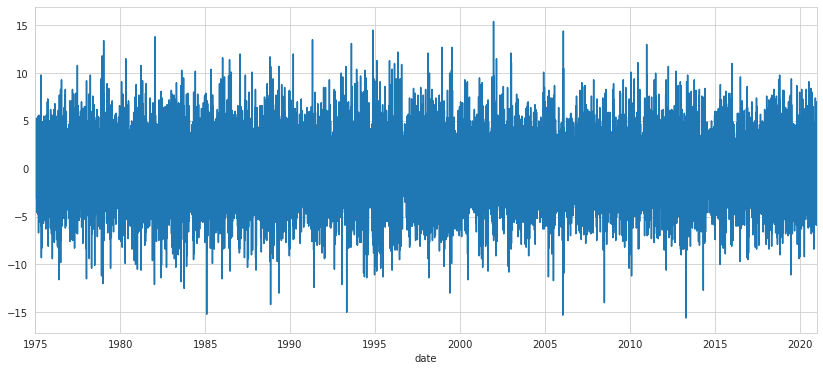

In [81]:
# plot the first seasonal difference 

temp_train['seasonal_diff1'].plot();

In [82]:
# check results of adfuller test

adfuller_test(temp_train['seasonal_diff1'].dropna())

ADF Test Statistic : -33.05493232007026
p-value : 0.0
#Lags Used : 44
Number of Observations Used : 16744
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


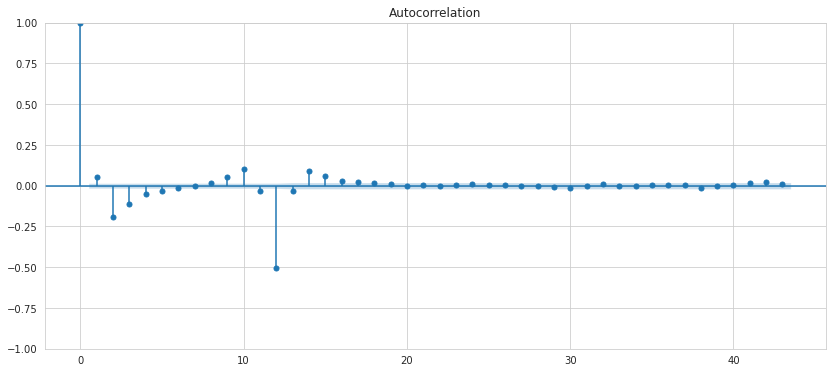

In [83]:
plot_acf(temp_train['seasonal_diff1'].dropna());

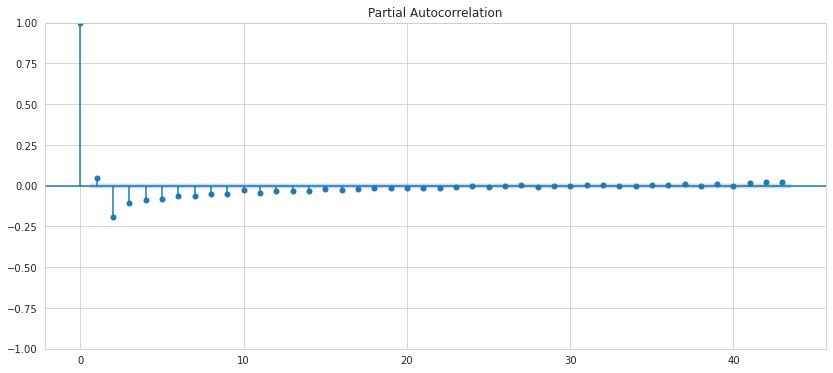

In [84]:
plot_pacf(temp_train['diff1'].dropna());

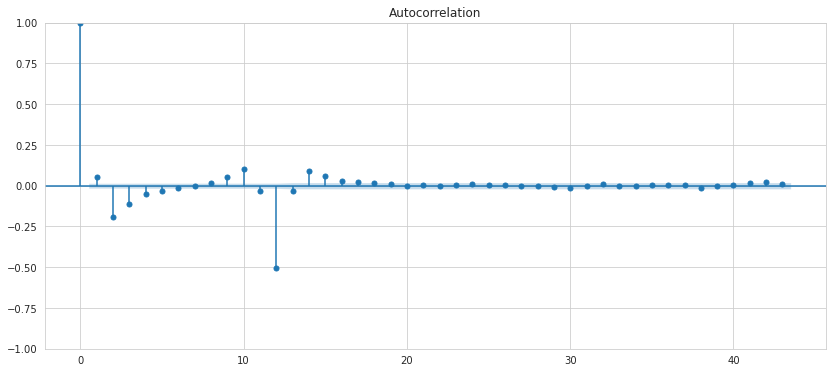

In [85]:
plot_acf(temp_train['seasonal_diff1'].dropna());

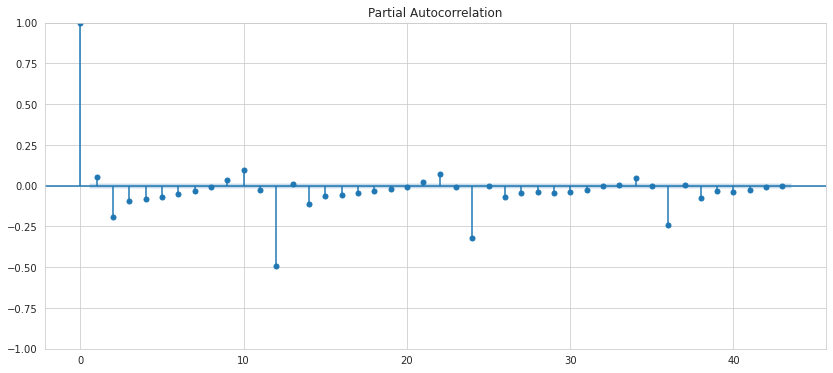

In [86]:
plot_pacf(temp_train['seasonal_diff1'].dropna());

In [87]:
auto_arima_model = auto_arima(temp_train['temp'] , 
                              start_p = 0        , 
                              start_q = 0        , 
                              max_p = 15         , 
                              max_q = 15         , 
                              max_d = 2)

In [88]:
auto_arima_model

ARIMA(order=(3, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [89]:
# fit and ARIMA (3,1,1) model (p,d,q)

model = ARIMA(temp_train['temp'], order = (3,1,1)).fit()

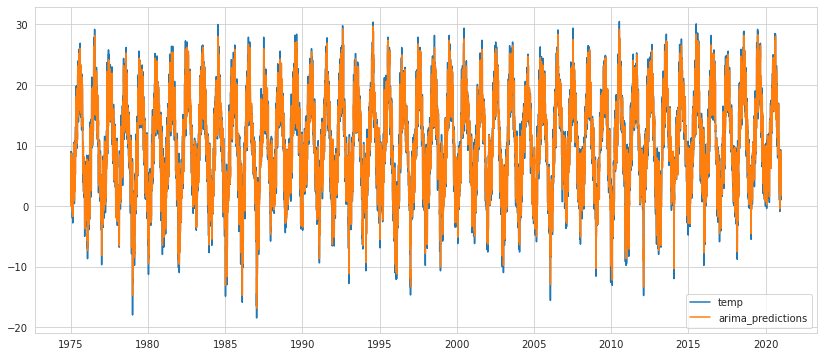

In [90]:
plt.plot(temp_train['temp'], label = 'temp')
plt.plot(model.predict(), label = 'arima_predictions')  # this is called in-sample predictions, predictions on test data
plt.legend();

In [91]:
# calculate rmse on training data

rmse_no_seasonality = np.sqrt(mean_squared_error(temp_train['temp'], model.predict()))

rmse_no_seasonality

2.2664395682301826

In [92]:
model.forecast()

2021-01-01    2.811377
Freq: D, dtype: float64

In [103]:
model.predict(start = '2021-01-01', end = '2021-01-31')

2021-01-01    2.811377
2021-01-02    2.984623
2021-01-03    3.092941
2021-01-04    3.159183
2021-01-05    3.201534
2021-01-06    3.229181
2021-01-07    3.247193
2021-01-08    3.258871
2021-01-09    3.266433
2021-01-10    3.271331
2021-01-11    3.274506
2021-01-12    3.276564
2021-01-13    3.277898
2021-01-14    3.278762
2021-01-15    3.279322
2021-01-16    3.279685
2021-01-17    3.279921
2021-01-18    3.280073
2021-01-19    3.280172
2021-01-20    3.280236
2021-01-21    3.280277
2021-01-22    3.280304
2021-01-23    3.280322
2021-01-24    3.280333
2021-01-25    3.280340
2021-01-26    3.280345
2021-01-27    3.280348
2021-01-28    3.280350
2021-01-29    3.280351
2021-01-30    3.280352
2021-01-31    3.280353
Freq: D, Name: predicted_mean, dtype: float64

In [94]:
temp_test = pd.read_csv(PATH + 'climate_test.csv', parse_dates = True, index_col = 0)
temp_test.tail()

,temp
date,
2021-12-27,-3.9
2021-12-28,-0.5
2021-12-29,4.5
2021-12-30,9.3
2021-12-31,13.0


In [102]:
# add predictions from both models

temp_test['arima_predictions'] = model.predict(start = '2021-01-01', end = '2021-01-10').values

ValueError: Length of values (10) does not match length of index (365)

In [96]:
temp_test

,temp,arima_predictions
date,,
2021-01-01,2.1,2.811377
2021-01-02,1.1,2.984623
2021-01-03,0.6,3.092941
2021-01-04,0.8,3.159183
2021-01-05,1.7,3.201534
...,...,...
2021-12-27,-3.9,3.280354
2021-12-28,-0.5,3.280354
2021-12-29,4.5,3.280354


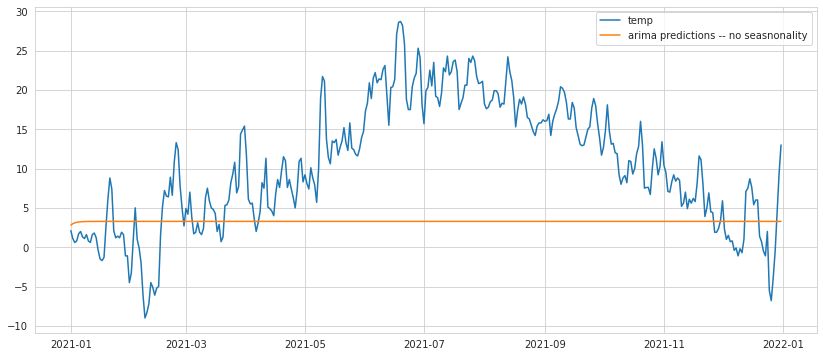

In [97]:
plt.plot(temp_test['temp'], label='temp')
plt.plot(temp_test['arima_predictions'], label='arima predictions -- no seasnonality')
plt.legend();

In [98]:
test_rmse_no_seasonality = np.sqrt(mean_squared_error(temp_test['temp'], temp_test['arima_predictions']))

test_rmse_no_seasonality

ValueError: Found input variables with inconsistent numbers of samples: [16802, 365]

In [99]:
### introducing SARIMAX to handle seasonailty and hopefully get a better model (measure by rmse on test data)

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [100]:
# the seasonal arima has 7 different hyperparameters: (p,d,q)(P,D,Q,m)
# m here is the series period, which we know is 12
# we can also use auto_arima to help us identify the best model


auto_arima_model = auto_arima(temp_train['temp']   , 
                              start_p  = 0         , 
                              start_q  = 0         , 
                              max_p    = 10        , 
                              max_q    = 10        , 
                              max_d    = 2         , 
                              seasonal = True      , 
                              start_P  = 0         , 
                              start_Q  = 0         , 
                              max_D    = 2         , 
                              m        = 12        , 
                              max_P    = 10        , 
                              max_Q    = 10        ,
                              trace    = True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=76624.831, Time=0.24 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=76590.762, Time=2.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=76569.680, Time=3.59 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=76622.831, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=76568.900, Time=0.86 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=76569.666, Time=2.77 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=76571.402, Time=11.06 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=75778.692, Time=3.65 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=75780.654, Time=13.51 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=75780.655, Time=19.57 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=75782.646, Time=15.55 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=76590.123, Time=0.63 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=75214.786, Time=3.42 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=75213.944, Time=11.30 sec


In [ ]:
auto_arima_model

In [ ]:
sarima_model = SARIMAX(temp_train['temp'], 
                       order = (3,1,1), 
                       seasonal_order = (0,0,0,12)).fit()

In [ ]:
# calculate train error

rmse_sarima = np.sqrt(mean_squared_error(temp_train['temp'], 
                                         sarima_model.predict()))

In [ ]:
rmse_sarima

In [ ]:
plt.plot(temp_train['temp'], label = 'temp_data')
plt.plot(sarima_model.predict(), label = 'sarima predictions')
plt.plot(model.predict(), label = 'arima predictions')
plt.legend()

plt.show()

In [ ]:
# to compare correctly, drop the first period (12 months) of both predictions

rmse_no_seasonality = np.sqrt(mean_squared_error(temp_train['temp'].loc['1980':'1989'],
                                                model.predict().loc['1980':'1989']))

rmse_sarima = np.sqrt(mean_squared_error(temp_train['temp'].loc['1980':'1989'],
                                                sarima_model.predict().loc['1980':'1989']))

print(rmse_no_seasonality, rmse_sarima)

In [ ]:
temp_test['sarima_predictions'] = sarima_model.predict(start = '2021-01-01', end = '2021-12-31')

plt.plot(temp_test['temp']               , label = 'temp_data')
plt.plot(temp_test['sarima_predictions'] , label = 'sarima predictions')
#plt.plot(temp_test['arima_predictions']  , label = 'arima predictions')
plt.legend()

plt.show()

In [ ]:
temp_test

#### Step 6.2 - run the baseline model

#### Step 6.3 - evaluate the model

In [ ]:
### neu

In [106]:
# the txt-file contains information as seen above. therefore we skip the first 18 rows.
PATH = '/home/florianriemann/data_science_portfolio/boot_camp/data/data_temperature/'
raw_data = pd.read_csv(PATH + 'TG_STAID002759.txt', delimiter = ",", skiprows = 18)

In [107]:
raw_data

,SOUID,DATE,TG,Q_TG
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0
...,...,...,...,...
53564,111448,20220827,205,0
53565,111448,20220828,177,0
53566,100133,20220829,166,0
53567,100133,20220830,172,0


In [108]:
raw_data.columns = ['id', 'date', 'temp', 'quality']

raw_data.head()

,id,date,temp,quality
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0


In [109]:
# checking data coming from a single station

raw_data['id'].nunique()

4

In [110]:
# checking all data points are not missing

raw_data['quality'].value_counts()

0    53372
9      196
1        1
Name: quality, dtype: int64

In [111]:
# changing date column to pandas datetime format

raw_data['date'] = raw_data['date'].astype(str)

raw_data['date'] = pd.to_datetime(raw_data['date'])

raw_data.head()

,id,date,temp,quality
0,127488,1876-01-01,22,0
1,127488,1876-01-02,25,0
2,127488,1876-01-03,3,0
3,127488,1876-01-04,-58,0
4,127488,1876-01-05,-98,0


In [114]:
# dropping id and quality column

raw_data.drop(['id', 'quality'], axis=1, inplace=True)

raw_data.head()

,date,temp
0,1876-01-01,22
1,1876-01-02,25
2,1876-01-03,3
3,1876-01-04,-58
4,1876-01-05,-98


In [116]:
clean_data = raw_data.set_index("date")

clean_data.head()

,temp
date,
1876-01-01,22
1876-01-02,25
1876-01-03,3
1876-01-04,-58
1876-01-05,-98


<AxesSubplot:xlabel='date'>

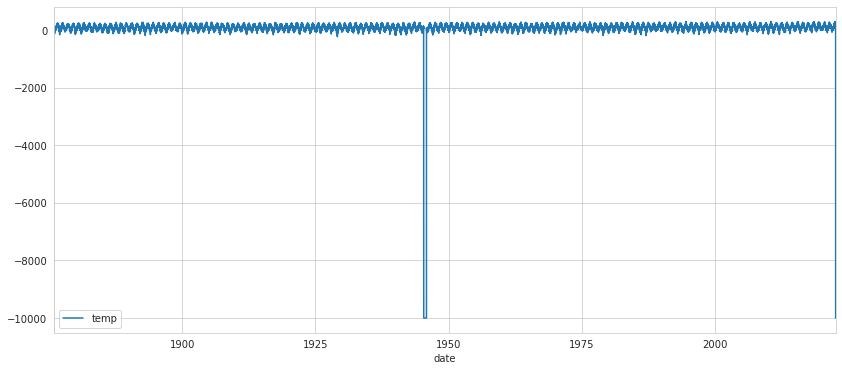

In [117]:
# taking a look at the data

clean_data.plot()